In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

# D. Cashon
# run on CUDA enabled tflow with a 1050Ti
# may take forever if not GPU bound

<h2>Extract MNIST data</h2>

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
#get mnist data, with one_hot encoding
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)
#suppress warnings
tf.logging.set_verbosity(old_v)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
train_imgs = mnist.train.images
train_labels = mnist.train.labels
test_imgs = mnist.test.images
test_labels = mnist.test.labels

<h2>Define hyperparameters</h2>

In [4]:
num_epochs = 1000 # to vary later
lr = 0.001 # to vary later
n_per_layer = [256, 128, 64]
num_layers = len(n_per_layer)
batch_size = 64

<h2>Define placeholder and Variables</h2>

In [5]:
# input layer is invariant
tf.reset_default_graph()
x_in = tf.placeholder(dtype=tf.float32, shape=[None, 784])

# define true labels
y_hat = tf.placeholder(dtype=tf.float32, shape=[None, 10])

weights, biases = {}, {}
for i in range(num_layers):
    wkey = 'W' + str(i)
    bkey = 'B' + str(i)
    if i == 0:
        # first layer, use input dim
        weights[wkey] = tf.get_variable(wkey, shape=[784, n_per_layer[i]])
        biases[bkey] = tf.get_variable(bkey, shape=[1,1])
    else:
        # other layers, use dim and dim-1
        weights[wkey] = tf.get_variable(wkey, shape=[n_per_layer[i-1], n_per_layer[i]])
        biases[bkey] = tf.get_variable(bkey, shape=[1,1])

# add output layer weight and bias
wkey_out = 'W' + str(num_layers)
bkey_out = 'B' + str(num_layers)
weights[wkey_out] = tf.get_variable(wkey_out, shape=[n_per_layer[num_layers-1], 10])
biases[bkey_out] = tf.get_variable(bkey_out, shape=[1,1])


Instructions for updating:
Colocations handled automatically by placer.


<h2>Define neural network</h2>

In [6]:
# for now sigmoid activation, but will try others too
layers_out = []
for i, wb in enumerate(list(zip(weights, biases))):
    if i == 0:
        # first layer, needs x_in
        layers_out.append(tf.nn.sigmoid(tf.add(tf.matmul(x_in, weights[wb[0]]), biases[wb[1]])))
    else:
        layers_out.append(tf.nn.sigmoid(tf.add(tf.matmul(layers_out[i-1], weights[wb[0]]), biases[wb[1]])))
logits = layers_out[-1]

<h2>Define cost function and accuracy</h2>

In [7]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_hat))
#define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(cost)

#compare the predicted labels with true labels
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(y_hat,1))

#compute the accuracy by taking average
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

#Initialize the variables

<h2>Execute training</h2>

Sample Test Accuracy 	 0.109375
Accuracy 	 0.109375
Cost 	2.2888012
Sample Test Accuracy 	 0.6875
Accuracy 	 0.625
Cost 	1.9268458
Sample Test Accuracy 	 0.8125
Accuracy 	 0.765625
Cost 	1.8056707
Sample Test Accuracy 	 0.796875
Accuracy 	 0.75
Cost 	1.730434
Sample Test Accuracy 	 0.828125
Accuracy 	 0.8125
Cost 	1.728391
Sample Test Accuracy 	 0.890625
Accuracy 	 0.828125
Cost 	1.6609378
Sample Test Accuracy 	 0.9375
Accuracy 	 0.9375
Cost 	1.5869373
Sample Test Accuracy 	 0.9375
Accuracy 	 0.875
Cost 	1.5902412
Sample Test Accuracy 	 0.890625
Accuracy 	 0.875
Cost 	1.589408
Sample Test Accuracy 	 0.859375
Accuracy 	 nan
Cost 	nan
Wall time: 4.13 s


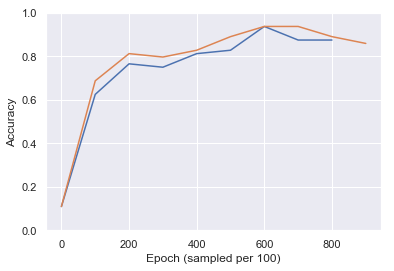

In [8]:
%%time
init = tf.global_variables_initializer()
epoch, train_acc, test_acc = [], [], []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_epochs):
        # assuming we dont get to the end before num_epochs finishes
        batch_start = i * batch_size
        batch_end = i * batch_size + batch_size
        # train
        sess.run(train_op, feed_dict={x_in: train_imgs[batch_start:batch_end, :], y_hat: train_labels[batch_start:batch_end, :]})
        if i % 100 == 0:
            # print accuracy
            acc = sess.run(accuracy, feed_dict={x_in: train_imgs[batch_start:batch_end, :], y_hat: train_labels[batch_start:batch_end, :]})
            yolo = sess.run(cost, feed_dict={x_in: train_imgs[batch_start:batch_end, :], y_hat: train_labels[batch_start:batch_end, :]})
            yolo2 = sess.run(accuracy, feed_dict={x_in: test_imgs[batch_size:2*batch_size, :], y_hat: test_labels[batch_size:2*batch_size, :]})
            print('Sample Test Accuracy \t ' + str(yolo2))
            print('Accuracy \t ' + str(acc))
            print('Cost \t' + str(yolo))
            epoch.append(i)
            train_acc.append(acc)
            test_acc.append(yolo2)
            
plt.figure(1)
plt.plot(epoch, train_acc, label='Train')
plt.plot(epoch, test_acc, label='Test')
plt.grid(True)
plt.xlabel('Epoch (sampled per 100)')
plt.ylabel('Accuracy')
plt.ylim(0,1)

<h2>Your results</h2>